In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.evaluator import find_learning_curve_intersection, fit_learning_curve, lc
from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(["science", "nature"])
%matplotlib inline

## Load results

In [35]:
all_out = glob("out/**/*.pkl")

In [36]:
all_out = [load_pickle(p) for p in all_out]

In [37]:
all_out

[{'tabpfn_metrics': {'accuracy': 0.6687116564417178,
   'acc_macro': 0.6687116564417178,
   'racc': 0.6687116564417178,
   'kappa': 0.0,
   'confusion_matrix': pycm.ConfusionMatrix(classes: [0, 1]),
   'f1_macro': 0.4007352941176471,
   'f1_micro': 0.6687116564417178,
   'frac_valid': 1.0,
   'all_y_true': (#326) [1,1,1,1,1,0,0,0,0,0...],
   'all_y_pred': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [38]:
extracted_res = []
xgboost_results = []
tabpfn_results = []
dummy_results = []

for out in all_out:
    res = {
        "train_size": out["train_size"],
        "frac_valid": out["frac_valid"],
        "accuracy": out["accuracy"],
        "f1_macro": out["f1_macro"],
        "f1_micro": out["f1_micro"],
        "kappa": out["kappa"],
    }

    xgb_res = {
        "train_size": out["train_size"],
        "accuracy": out["xgb_metrics"]["accuracy"],
        "f1_macro": out["xgb_metrics"]["f1_macro"],
        "f1_micro": out["xgb_metrics"]["f1_micro"],
        "kappa": out["xgb_metrics"]["kappa"],
    }

    tabpfn_res = {
        "train_size": out["train_size"],
        "accuracy": out["tabpfn_metrics"]["accuracy"],
        "f1_macro": out["tabpfn_metrics"]["f1_macro"],
        "f1_micro": out["tabpfn_metrics"]["f1_micro"],
        "kappa": out["tabpfn_metrics"]["kappa"],
    }

    dummy_res = {
        "train_size": out["train_size"],
        "accuracy": out["dummy_metrics"]["accuracy"],
        "f1_macro": out["dummy_metrics"]["f1_macro"],
        "f1_micro": out["dummy_metrics"]["f1_micro"],
        "kappa": out["dummy_metrics"]["kappa"],
    }

    extracted_res.append(res)
    xgboost_results.append(xgb_res)
    tabpfn_results.append(tabpfn_res)
    dummy_results.append(dummy_res)

In [39]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)
dummy_res = pd.DataFrame(dummy_results)

In [40]:
grouped_res = res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [41]:
grouped_xgboost_res = xgboost_res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [42]:
grouped_dummy_res = dummy_res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [43]:
grouped_tabpfn_res = tabpfn_res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [44]:
grouped_res.loc[:]

frac_valid                  accuracy                            \
                 mean  std count  sem      mean       std count       sem   
train_size                                                                  
10                1.0  0.0     3  0.0  0.690044  0.019458     3  0.011234   
20                1.0  0.0     3  0.0  0.647293  0.097490     3  0.056286   
50                1.0  0.0     2  0.0  0.753164  0.033808     2  0.023906   

            f1_macro                            f1_micro                  \
                mean       std count       sem      mean       std count   
train_size                                                                 
10          0.480067  0.070089     3  0.040466  0.690044  0.019458     3   
20          0.459582  0.048968     3  0.028272  0.647293  0.097490     3   
50          0.579482  0.032923     2  0.023280  0.753164  0.033808     2   

                         kappa                            
                 sem      mean       std count       sem  
train_size                                                
10          0.011234  0.018832  0.096212     3  0.055548  
20          0.056286  0.010821  0.069899     3  0.040356  
50          0.023906  0.178158  0.038781     2  0.027422

In [45]:
grouped_tabpfn_res

accuracy                            f1_macro                  \
                mean       std count       sem      mean       std count   
train_size                                                                 
10          0.652350  0.012572     3  0.007258  0.394778  0.004622     3   
20          0.586892  0.124060     3  0.071626  0.396346  0.003934     3   
50          0.727241  0.160546     2  0.113523  0.518673  0.139107     2   

                      f1_micro                               kappa            \
                 sem      mean       std count       sem      mean       std   
train_size                                                                     
10          0.002669  0.652350  0.012572     3  0.007258  0.000000  0.000000   
20          0.002272  0.586892  0.124060     3  0.071626 -0.047691  0.082603   
50          0.098363  0.727241  0.160546     2  0.113523  0.145185  0.148973   

                            
           count       sem  
train_size                  
10             3  0.000000  
20             3  0.047691  
50             2  0.105340

In [46]:
grouped_xgboost_res

accuracy                            f1_macro                  \
                mean       std count       sem      mean       std count   
train_size                                                                 
10          0.624129  0.074303     3  0.042899  0.471331  0.129681     3   
20          0.603057  0.082365     3  0.047553  0.412620  0.027625     3   
50          0.705903  0.145685     2  0.103015  0.501913  0.143715     2   

                      f1_micro                               kappa            \
                 sem      mean       std count       sem      mean       std   
train_size                                                                     
10          0.074872  0.624129  0.074303     3  0.042899  0.024627  0.210751   
20          0.015949  0.603057  0.082365     3  0.047553 -0.035754  0.038311   
50          0.101622  0.705903  0.145685     2  0.103015  0.111210  0.141577   

                            
           count       sem  
train_size                  
10             3  0.121677  
20             3  0.022119  
50             2  0.100110

In [47]:
grouped_dummy_res

accuracy                            f1_macro                  \
                mean       std count       sem      mean       std count   
train_size                                                                 
10          0.652350  0.012572     3  0.007258  0.394778  0.004622     3   
20          0.519516  0.240544     3  0.138878  0.329577  0.116730     3   
50          0.718641  0.163700     2  0.115753  0.415494  0.055674     2   

                      f1_micro                           kappa                  
                 sem      mean       std count       sem  mean  std count  sem  
train_size                                                                      
10          0.002669  0.652350  0.012572     3  0.007258   0.0  0.0     3  0.0  
20          0.067394  0.519516  0.240544     3  0.138878   0.0  0.0     3  0.0  
50          0.039367  0.718641  0.163700     2  0.115753   0.0  0.0     2  0.0

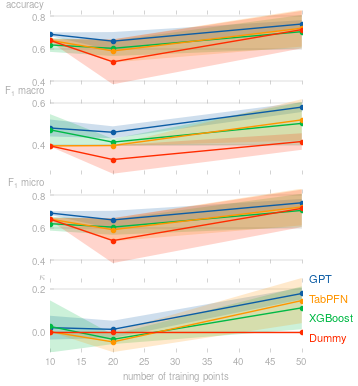

In [48]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(
        4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex="all"
    )

    # plot the binary case, i.e. num_classes = 2

    for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
        ax[i].plot(
            grouped_res.loc[ :].index,
            grouped_res.loc[:][metric]["mean"],
            marker="o",
            label="GPT",
        )
        ax[i].fill_between(
            grouped_res.loc[ :].index,
            grouped_res.loc[:][metric]["mean"] - grouped_res.loc[ :][metric]["sem"],
            grouped_res.loc[ :][metric]["mean"] + grouped_res.loc[ :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_xgboost_res.loc[ :].index,
            grouped_xgboost_res.loc[ :][metric]["mean"],
            marker="o",
            label="XGBoost",
        )
        ax[i].fill_between(
            grouped_xgboost_res.loc[ :].index,
            grouped_xgboost_res.loc[:][metric]["mean"]
            - grouped_xgboost_res.loc[ :][metric]["sem"],
            grouped_xgboost_res.loc[:][metric]["mean"]
            + grouped_xgboost_res.loc[:][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_tabpfn_res.loc[ :].index,
            grouped_tabpfn_res.loc[ :][metric]["mean"],
            marker="o",
            label="TabPFN",
        )
        ax[i].fill_between(
            grouped_tabpfn_res.loc[ :].index,
            grouped_tabpfn_res.loc[:][metric]["mean"]
            - grouped_tabpfn_res.loc[ :][metric]["sem"],
            grouped_tabpfn_res.loc[ :][metric]["mean"]
            + grouped_tabpfn_res.loc[:][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_dummy_res.loc[ :].index,
            grouped_dummy_res.loc[ :][metric]["mean"],
            marker="o",
            label="Dummy",
        )
        ax[i].fill_between(
            grouped_dummy_res.loc[ :].index,
            grouped_dummy_res.loc[:][metric]["mean"]
            - grouped_dummy_res.loc[ :][metric]["sem"],
            grouped_dummy_res.loc[ :][metric]["mean"]
            + grouped_dummy_res.loc[:][metric]["sem"],
            alpha=0.2,
        )

    matplotx.line_labels(ax[-1], fontsize=8)
    matplotx.ylabel_top("accuracy", ax=ax[0])
    matplotx.ylabel_top(r"F$_{1}$ macro", ax=ax[1])
    matplotx.ylabel_top(r"F$_{1}$ micro", ax=ax[2])
    matplotx.ylabel_top(r"$\kappa$", ax=ax[3])
    ax[-1].set_xlabel("number of training points", labelpad=4)

    fig.savefig("mof_synthesizability-classification_results_2.pdf", bbox_inches="tight")

In [32]:
find_learning_curve_intersection(
    grouped_res.loc[2, :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

KeyError: 2

In [ ]:
find_learning_curve_intersection(
    grouped_res.loc[2, :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

KeyError: 2

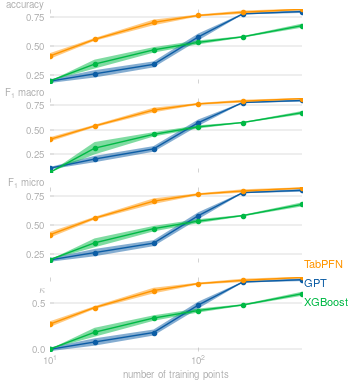

In [12]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(
        4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex="all"
    )

    # plot the binary case, i.e. num_classes = 2

    for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
        ax[i].plot(
            grouped_res.loc[5, :].index,
            grouped_res.loc[5, :][metric]["mean"],
            marker="o",
            label="GPT",
        )
        ax[i].fill_between(
            grouped_res.loc[5, :].index,
            grouped_res.loc[5, :][metric]["mean"] - grouped_res.loc[5, :][metric]["sem"],
            grouped_res.loc[5, :][metric]["mean"] + grouped_res.loc[5, :][metric]["sem"],
            alpha=0.5,
        )

        ax[i].plot(
            grouped_xgboost_res.loc[5, :].index,
            grouped_xgboost_res.loc[5, :][metric]["mean"],
            marker="o",
            label="XGBoost",
        )
        ax[i].fill_between(
            grouped_xgboost_res.loc[5, :].index,
            grouped_xgboost_res.loc[5, :][metric]["mean"]
            - grouped_xgboost_res.loc[5, :][metric]["sem"],
            grouped_xgboost_res.loc[5, :][metric]["mean"]
            + grouped_xgboost_res.loc[5, :][metric]["sem"],
            alpha=0.5,
        )

        ax[i].plot(
            grouped_tabpfn_res.loc[5, :].index,
            grouped_tabpfn_res.loc[5, :][metric]["mean"],
            marker="o",
            label="TabPFN",
        )
        ax[i].fill_between(
            grouped_tabpfn_res.loc[5, :].index,
            grouped_tabpfn_res.loc[5, :][metric]["mean"]
            - grouped_tabpfn_res.loc[5, :][metric]["sem"],
            grouped_tabpfn_res.loc[5, :][metric]["mean"]
            + grouped_tabpfn_res.loc[5, :][metric]["sem"],
            alpha=0.5,
        )

    matplotx.line_labels(ax[-1], fontsize=8)
    matplotx.ylabel_top("accuracy", ax=ax[0])
    matplotx.ylabel_top(r"F$_{1}$ macro", ax=ax[1])
    matplotx.ylabel_top(r"F$_{1}$ micro", ax=ax[2])
    matplotx.ylabel_top(r"$\kappa$", ax=ax[3])
    ax[-1].set_xlabel("number of training points", labelpad=4)

    ax[0].set_xscale("log")
    fig.savefig("polymner-classification_results_5.pdf", bbox_inches="tight")